In [99]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# progress bar imports
from time import sleep
from tqdm import tqdm
from torchviz import make_dot
from torchinfo import summary

In [100]:
dataRoot = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [101]:
# Get caltech dataset
batch_size = 64
val_size = 5000
dataSet = datasets.CIFAR10(root=dataRoot, train=True, download=True, transform=transforms.ToTensor())
trainSet, valSet = torch.utils.data.random_split(dataset, [len(dataSet), val_size])
testSet = datasets.CIFAR10(root=dataRoot, train=False, download=True, transform=transforms.ToTensor())

trainLoader = DataLoader(trainSet, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valLoader = DataLoader(valSet, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testLoader = DataLoader(testSet, batch_size=batch_size, num_workers=4, pin_memory=True)

print("trainSet dataset size", len(trainSet))
print("testSet dataset size", len(testSet))
print("classes", trainSet.classes)

Files already downloaded and verified
Files already downloaded and verified


In [102]:
firstDatapoint = trainSet[0]
firstImage = firstDatapoint[0]
firstLabel = firstDatapoint[1]
print("label", firstLabel)
print("shape", firstImage.shape)

label 6
shape torch.Size([3, 32, 32])


In [103]:
class CifarNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.name = 'CifarNetwork'
        # TODO what happens when kernel size is even?
        self.conv1 = nn.Conv2d(3, 32, 3, 1) # 32x32 -> 30x30, no padding
        self.conv2 = nn.Conv2d(32, 64, 5, 1) # 30x30 -> 26x26
        
        self.batch_flattener = nn.Flatten(start_dim=1) # make flat from dim 1
        
        self.fc1 = nn.Linear(26*26*64, 10)
        self.activation = nn.LeakyReLU(0.01)
        self.LogSoftmax = nn.LogSoftmax(dim=1) # For batch, output is in dim 1 for each image.
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.batch_flattener(out)
#         print("shape after flattening", out.shape)
        out = self.fc1(out)
        out = self.activation(out)
        return self.LogSoftmax(out)
    

In [104]:
model = CifarNetwork().to(device)
lossFunc = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

CifarNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch_flattener): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=43264, out_features=10, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (LogSoftmax): LogSoftmax(dim=1)
)
Layer (type:depth-idx)                   Output Shape              Param #
CifarNetwork                             --                        --
├─Conv2d: 1-1                            [64, 32, 30, 30]          896
├─LeakyReLU: 1-2                         [64, 32, 30, 30]          --
├─Conv2d: 1-3                            [64, 64, 26, 26]          51,264
├─LeakyReLU: 1-4                         [64, 64, 26, 26]          --
├─Flatten: 1-5                           [64, 43264]               --
├─Linear: 1-6                            [64, 10]                  432,650
├─LeakyReLU: 1-7                         [64, 10]                  --
├─LogSoftmax: 1-8   

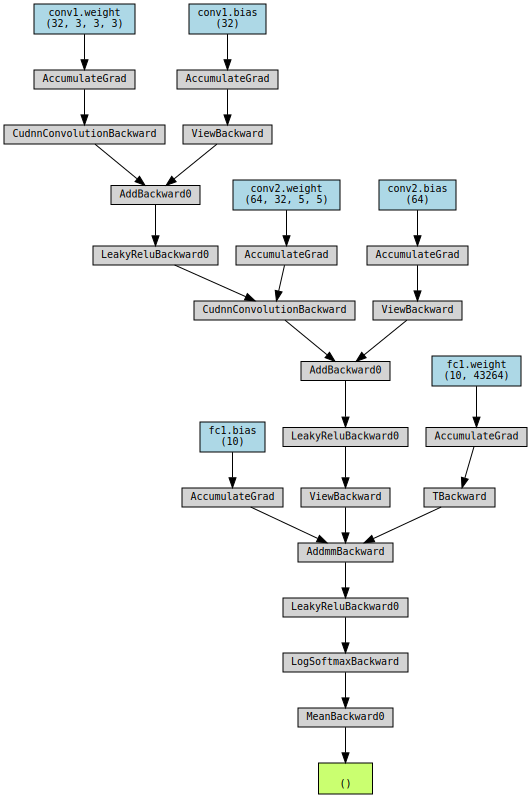

In [105]:
print(model)

print(summary(model, input_size=(batch_size, 3, 32, 32)))

y = model(testSet[0][0].unsqueeze(dim=0).to(device))
make_dot(y.mean(), params=dict(model.named_parameters()))

In [106]:
def saveCheckpoint(epoch, model, optimizer):
    
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
        
    }, f"{model.name}-checkpoint-{epoch}")

# train
batch_size_device = torch.tensor(batch_size, requires_grad=False).to(device)
n_epochs = 250
epoch_losses = []
for epoch in range(n_epochs):
#     print("Epoch:", epoch)
    epoch_loss = torch.tensor(0., requires_grad=False).to(device)
    
    with tqdm(trainLoader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for images, labels in tepoch:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)

            optimizer.zero_grad()
            batch_loss = lossFunc(output, labels)
            batch_loss.backward()
            optimizer.step()

            epoch_loss += batch_loss
            predictions = output.argmax(dim=1)
#             predictions2 = output.argmax(dim=1, keepdim=True).squeeze()
#             print("prediction1", predictions1)
#             print("predictions2", predictions2)
#             print("label shape", labels.shape)
#             print("predictions shape", predictions.shape)

            # prediction size fix
            if labels.size(0) < batch_size_device:
                predictions = predictions[:labels.size(0)]
#             elif predictions.size(0) < batch_size_device:
#                 predictions = predictions[:labels.size(0)]
            correct = (predictions == labels).sum()
            accuracy = correct / labels.size(0)

                
            tepoch.set_postfix(batch_loss=batch_loss.item(), accuracy=100. * accuracy.item())
#             sleep(0.1)

        
    # checkpoint
    if epoch % 10 == 0:
        saveCheckpoint(epoch, model, optimizer)
            
#     print(f"Epoch{epoch}, Average training loss: {epoch_loss / len(trainLoader)}")
    epoch_losses.append(epoch_loss.item())
    
saveCheckpoint(epoch, model, optimizer)
print(epoch_losses)
        

Epoch 67:  97%|█████████▋| 758/782 [00:08<00:00, 85.93batch/s, accuracy=100, batch_loss=0.0108] 


KeyboardInterrupt: 

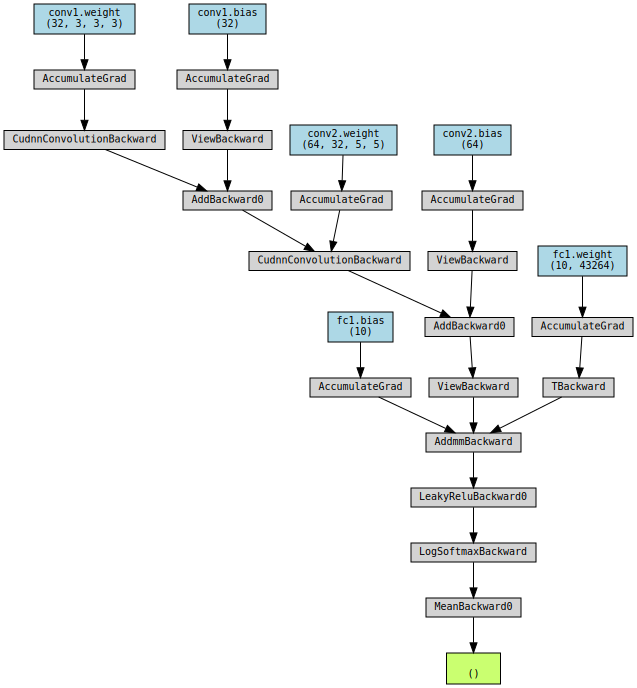

In [107]:
def evaluate(checkpointPath, testLoader, device, batch_size_device):
    checkpoint = torch.load(checkpointPath)
    model = CifarNetwork()
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = torch.tensor(0, requires_grad=False).to(device)
        total =  torch.tensor(0, requires_grad=False).to(device)
        for images, labels in testLoader:
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            predictions = output.argmax(dim=1)
            
            if labels.size(0) < batch_size_device:
                predictions = predictions[:labels.size(0)]
            
            correct += (predictions == labels).sum()
            total += labels.size(0)
        
        
        print(f"Testing accuracy: {100 * correct.item() / total.item()}")
    
    
    

In [111]:
evaluate('CifarNetwork-checkpoint-60', testLoader, device, batch_size_device)

Testing accuracy: 63.0
